In [48]:
import numpy as np
import scipy.special as sc
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [30]:
#constants
z3 = sc.zeta(3)
pi = np.pi
eta = 6.05e-10
e4 = np.exp(4)

#Gaussian units
q = 4.8032e-10
m = 9.1095e-28
c=3e10
kb=1.3803e-16
hbar=1.0546e-27
hc = 6.6262e-27*c
B = m*q**4/(2*hbar**2)
a0 = hbar**2/(m*q*q)
sig0 = 512*(pi*q*a0)**2/(3*e4*hbar*c)
A = sig0*c/np.sqrt(pi)*(q*q/(hbar*c))**3
r0 = q*q/(m*c*c)
#1eV in erg
ev = 1.6022e-12
#T0 in erg
T0 = 2.7255*kb
#constant factor in review
revA = 9.78*r0*r0*c

print(T0,'erg')
print(A/2)
print((revA-A/2)/(revA))

3.7620076499999994e-16 erg
2.0674519734556105e-14
0.11012964860860548


In [40]:
#functions temperatures are given in erg

#Temperature
def Temp(z):
    return T0*(1+z)
def xn(n, T):
    return B/(n*n*T)
#integral of e^x E1(x) from 0 to x
def inte(x):
    return np.exp(x)*sc.exp1(x)+0.577+np.log(x)
#lower bound (integral from n = 2 -> infty)
def lb(T):
    x2 = xn(2,T)
    return A*np.sqrt(x2)*inte(x2)
#upper bound (integral from n =1 -> infty)
def ub(T):
    x1 = xn(1,T)
    return 0.5*A*np.sqrt(x1)*inte(x1)
#trapezium approximation
def trap(T):
    x2 = xn(2,T)
    a2 = 0.5*A*x2*np.sqrt(x2)*np.exp(x2)*sc.exp1(x2)
    return a2+lb(T)
#Padmanabhan volume 3 approximation
def Pad3(T):
    return 2.6e-13*(ev/T)**0.8
#Padmanabhan cosmology review
def rev(T, amp):
    ratio = B/T
    #return revA*np.sqrt(ratio)*np.log(ratio)
    return amp*np.sqrt(ratio)*np.log(ratio)
#truncated sum
def a_sum(T, n):
    tot = 0
    for i in range(2,n+1):
        x = xn(i,T)
        tot += x*np.sqrt(x)*np.exp(x)*sc.exp1(x)
    return A*tot

In [58]:
print('recombination coefficients [cm^3s^-1] when T = 1 eV:')
print('lower bound:', lb(ev))
print('trapezium approximation:', trap(ev))
print('upper bound:', ub(ev))
print('Padmanabhan volume 3 fit:', Pad3(ev))
print('Padmanabhan review fit:', rev(ev, A/2))
print('sum to N = 10', a_sum(ev, 10))
print('sum to N = 100', a_sum(ev, 100))

recombination coefficients [cm^3s^-1] when T = 1 eV:
lower bound: 1.5537556161134852e-13
trapezium approximation: 1.8602978330374799e-13
upper bound: 2.4830885609446846e-13
Padmanabhan volume 3 fit: 2.6e-13
Padmanabhan review fit: 1.9906495915933126e-13
sum to N = 10 1.6392495723210023e-13
sum to N = 100 1.886746343077182e-13


In [54]:
Kelv = np.linspace(500, 10000, 500)
T = Kelv*kb

lower = lb(T)
upper = ub(T)
trapezium = trap(T)
P3 = Pad3(T)
review = rev(T, revA)
review_mine = rev(T, A/2)
a100 = a_sum(T, 100)
a10 = a_sum(T, 10)

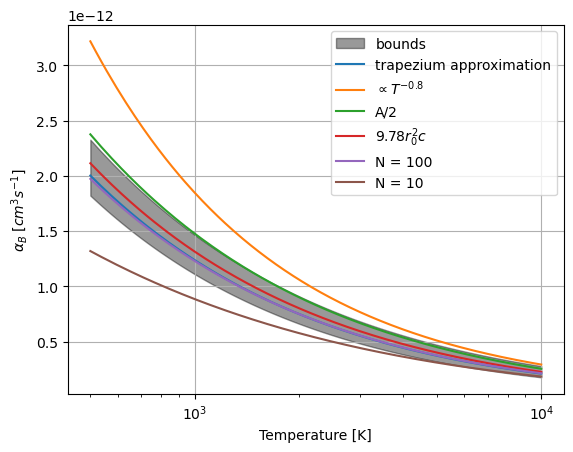

In [55]:
plt.fill_between(Kelv, lower, upper, color='black', alpha=0.4, label='bounds')
plt.plot(Kelv, trapezium, label='trapezium approximation')
plt.plot(Kelv, P3, label='$\propto T^{-0.8}$')
plt.plot(Kelv, review, label='A/2')
plt.plot(Kelv, review_mine, label='$9.78r^2_0c$')
plt.plot(Kelv, a100, label='N = 100')
plt.plot(Kelv, a10, label='N = 10')
plt.legend()
plt.grid()
plt.xlabel('Temperature [K]')
plt.ylabel('$\\alpha_B$ [$cm^3 s^{-1}$]')
plt.xscale('log')
#plt.yscale('log')
plt.savefig('Images/alpha_b graphs.png', dpi=300)
plt.show()

In [36]:
print((Pad3(kb*1000)-trap(kb*1000))/trap(kb*1000))

0.4928279125567869


In [65]:
#fitting function for aB
#fit function
def fit_func(x, a, b):
    #a = coefficient at 1 eV
    #b = temperature at 1 eV
    #c = power to fit
    return a*(ev/x)**b
p0 = np.array([2e-13, 0.8])
t = np.linspace(500, 10000, 1000)
x = kb*t
y_t = trap(x)
y_1000 = a_sum(x, 1000)

pt,ct = curve_fit(fit_func, x, y_t, p0)
p1000, c1000 = curve_fit(fit_func, x, y_1000, p0)
print(pt, np.sqrt(ct[0,0]), np.sqrt(ct[1,1]))
print(p1000, np.sqrt(c1000[0,0]), np.sqrt(c1000[1,1]))

[2.00339499e-13 7.40403713e-01] 2.772787545993684e-16 0.0006393605195780433
[2.03512608e-13 7.37503753e-01] 2.7431941442732544e-16 0.0006236193026100714


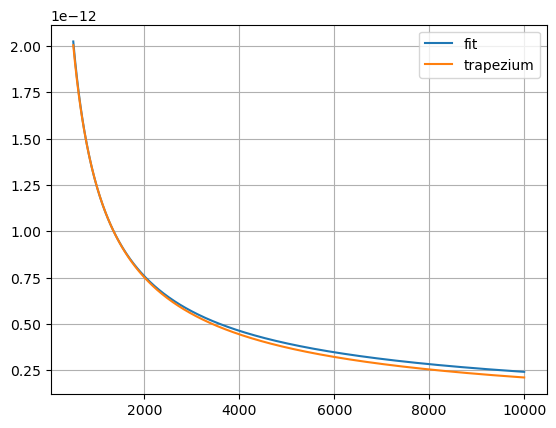

In [64]:
plt.plot(Kelv, fit_func(T, pt[0], pt[1]), label='fit')
plt.plot(Kelv, trapezium, label='trapezium')
plt.legend()
plt.grid()
plt.show()

In [18]:
def func(x):
    n1 = (1/(x+1))**2
    n = (1/x)**2
    top = n**3*np.exp(n1)*sc.exp1(n1)
    bottom = n1**3*np.exp(n)*sc.exp1(n)
    return top/bottom
x = np.linspace(1e4, 1e10,100)
y = func(x)

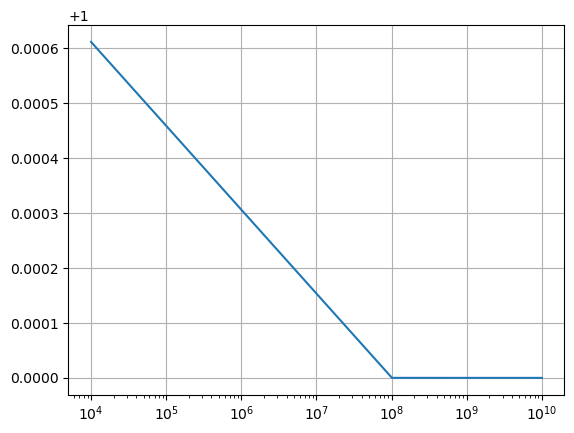

In [19]:
plt.plot(x,y)
plt.grid()
plt.xscale('log')
#plt.yscale('log')
plt.show()